# 02 - Exploratory Data Analysis

## Project Goal
This notebook performs in-depth Exploratory Data Analysis (EDA) on the combined dataset (`final_ballondor_pr_data.csv`).

## Objectives
1.  Engineer the **Target Variable** (`Vote Share`).
2.  Conduct **Detailed EDA** to visually confirm the relationship between PR proxies and the ranking.
3.  Save the data with the new target variable for the next notebook.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Set plot style and directory for saving figures
sns.set_style("whitegrid")
REPORT_PATH = '../reports/figures/'
os.makedirs(REPORT_PATH, exist_ok=True) # Ensure the directory exists

# Define the file path for the cleaned data from the previous notebook
FILE_PATH = '../data/final_ballondor_pr_data.csv'

# Load the data
df = pd.read_csv(FILE_PATH)

print(f"Data successfully loaded. Shape: {df.shape}")

Data successfully loaded. Shape: (120, 34)


In [6]:
print("--- Initial Data Information ---")
df.info(verbose=True)

--- Initial Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 34 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Year                                 120 non-null    int64  
 1   Rank                                 120 non-null    int64  
 2   Player                               120 non-null    object 
 3   Nationality                          120 non-null    object 
 4   Position                             120 non-null    object 
 5   Club                                 120 non-null    object 
 6   Points                               120 non-null    int64  
 7   League                               120 non-null    int64  
 8   League Rating                        120 non-null    float64
 9   League Top Scorer                    120 non-null    int64  
 10  League Top Assist Provider           120 non-null    int64  
 11 

## 1. Target Variable Engineering: Vote Share

The Ballon d'Or scoring system uses total points, which can vary by year. We create a standardized **Vote Share** to compare players fairly across different years (2022-2025).

$$\text{Vote Share} = \frac{\text{Player Points}}{\text{Maximum Points Awarded in that Year}}$$

In [7]:
# 1. Group by 'Year' and find the maximum points awarded (Rank 1 player's points)
max_points_per_year = df.groupby('Year')['Points'].max().reset_index()
max_points_per_year.rename(columns={'Points': 'Max_Points'}, inplace=True)

# 2. Merge this back into the main DataFrame
df = pd.merge(df, max_points_per_year, on='Year', how='left')

# 3. Calculate the final Target Variable: Vote Share (a value between 0 and 1)
df['Vote Share'] = df['Points'] / df['Max_Points']

# We keep 'Points' and 'Max_Points' for now to check correlations, but will drop them before modeling.

print("\nVote Share (Target Variable) created.")
print(df[['Rank', 'Points', 'Vote Share']].nlargest(5, 'Vote Share'))


Vote Share (Target Variable) created.
    Rank  Points  Vote Share
0      1     549    1.000000
30     1     462    1.000000
60     1    1170    1.000000
90     1    1380    1.000000
61     2    1129    0.964957


## 2. Exploratory Data Analysis (EDA)

The EDA section focuses on visualizing distributions and the direct relationship between PR proxies and the target variable, Vote Share.

### 2.1 Correlation Analysis: PR vs. Ranking

In [8]:
# Select key numerical and PR variables for correlation analysis
correlation_cols = [
    'Vote Share',
    'Rank',
    'Time-Weighted Google Trend Score',
    'Wiki Page Views',
    'Continental Cup Rating',
    'Other Rating', 
    'League Rating', 
    'UCL Rating',
    'WC Rating'
]

# Create the correlation matrix
corr_matrix = df[correlation_cols].corr()

print("Correlation matrix created.")

Correlation matrix created.


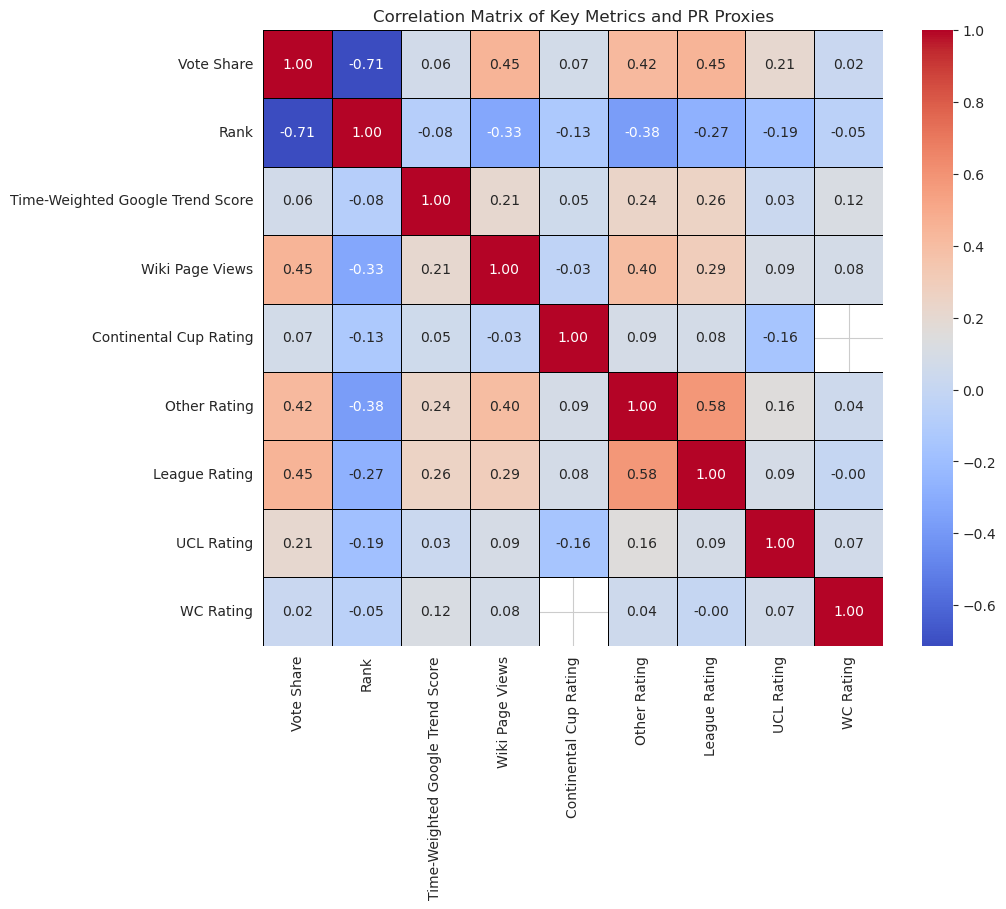

Correlation heatmap saved to ../reports/figures/correlation_heatmap.png.


In [9]:
plt.figure(figsize=(10, 8))
# Rank correlation should be negative, Vote Share correlation should be positive.
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f",
            linewidths=.5, 
            linecolor='black')
plt.title('Correlation Matrix of Key Metrics and PR Proxies')
plt.yticks(rotation=0)
plt.savefig(REPORT_PATH + 'correlation_heatmap.png')
plt.show()

print(f"Correlation heatmap saved to {REPORT_PATH}correlation_heatmap.png.")

### 2.2 Distribution of Key Variables

We visualize the distribution of the target and the PR proxies to understand their spread and check for skewness.

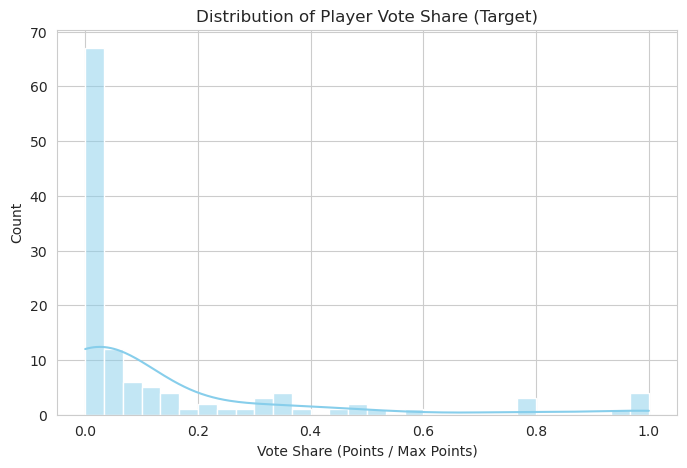

In [10]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Vote Share'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Player Vote Share (Target)')
plt.xlabel('Vote Share (Points / Max Points)')
plt.ylabel('Count')
plt.savefig(REPORT_PATH + 'vote_share_distribution.png')
plt.show()

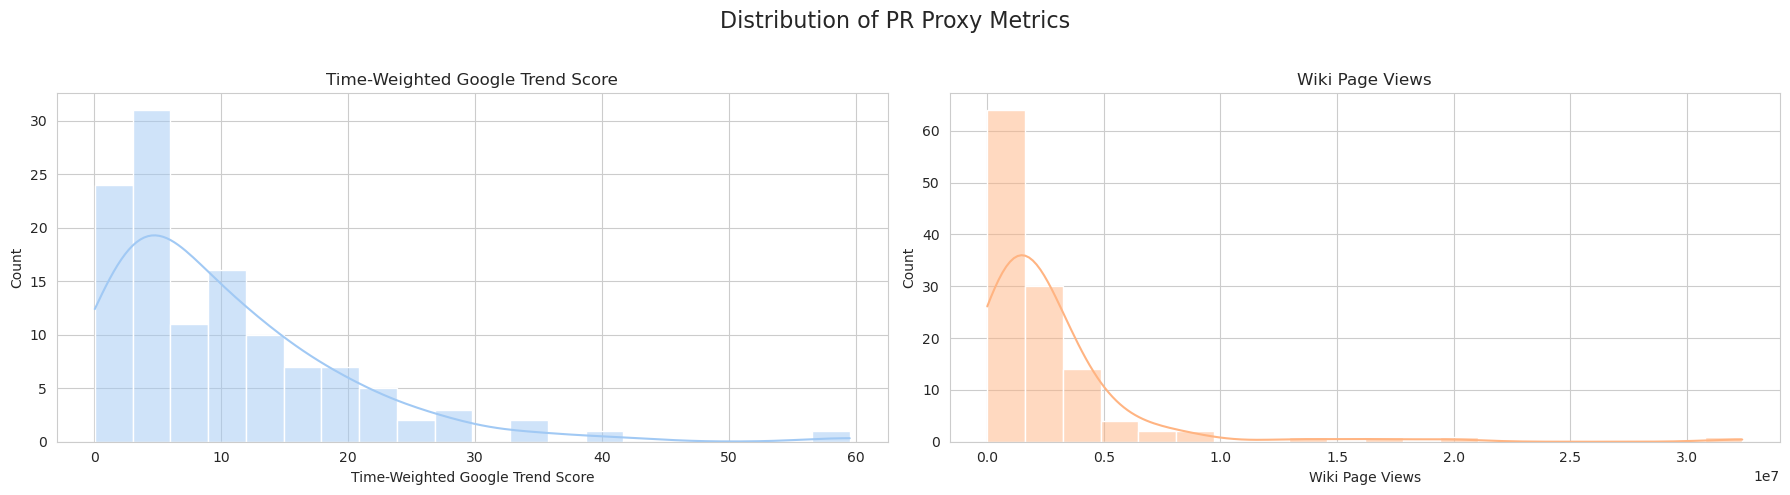

In [11]:
pr_proxies = ['Time-Weighted Google Trend Score', 'Wiki Page Views']

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
fig.suptitle('Distribution of PR Proxy Metrics', fontsize=16)

for i, col in enumerate(pr_proxies):
    sns.histplot(df[col], bins=20, kde=True, ax=axes[i], color=sns.color_palette("pastel")[i])
    axes[i].set_title(col)
    axes[i].set_xlabel(col)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(REPORT_PATH + 'pr_proxies_distribution.png')
plt.show()

### 2.3 Relationship: PR Proxies vs. Vote Share (Scatter Plots)

These scatter plots provide the most direct visual evidence for your hypothesis, showing if high PR activity leads to a higher Vote Share.

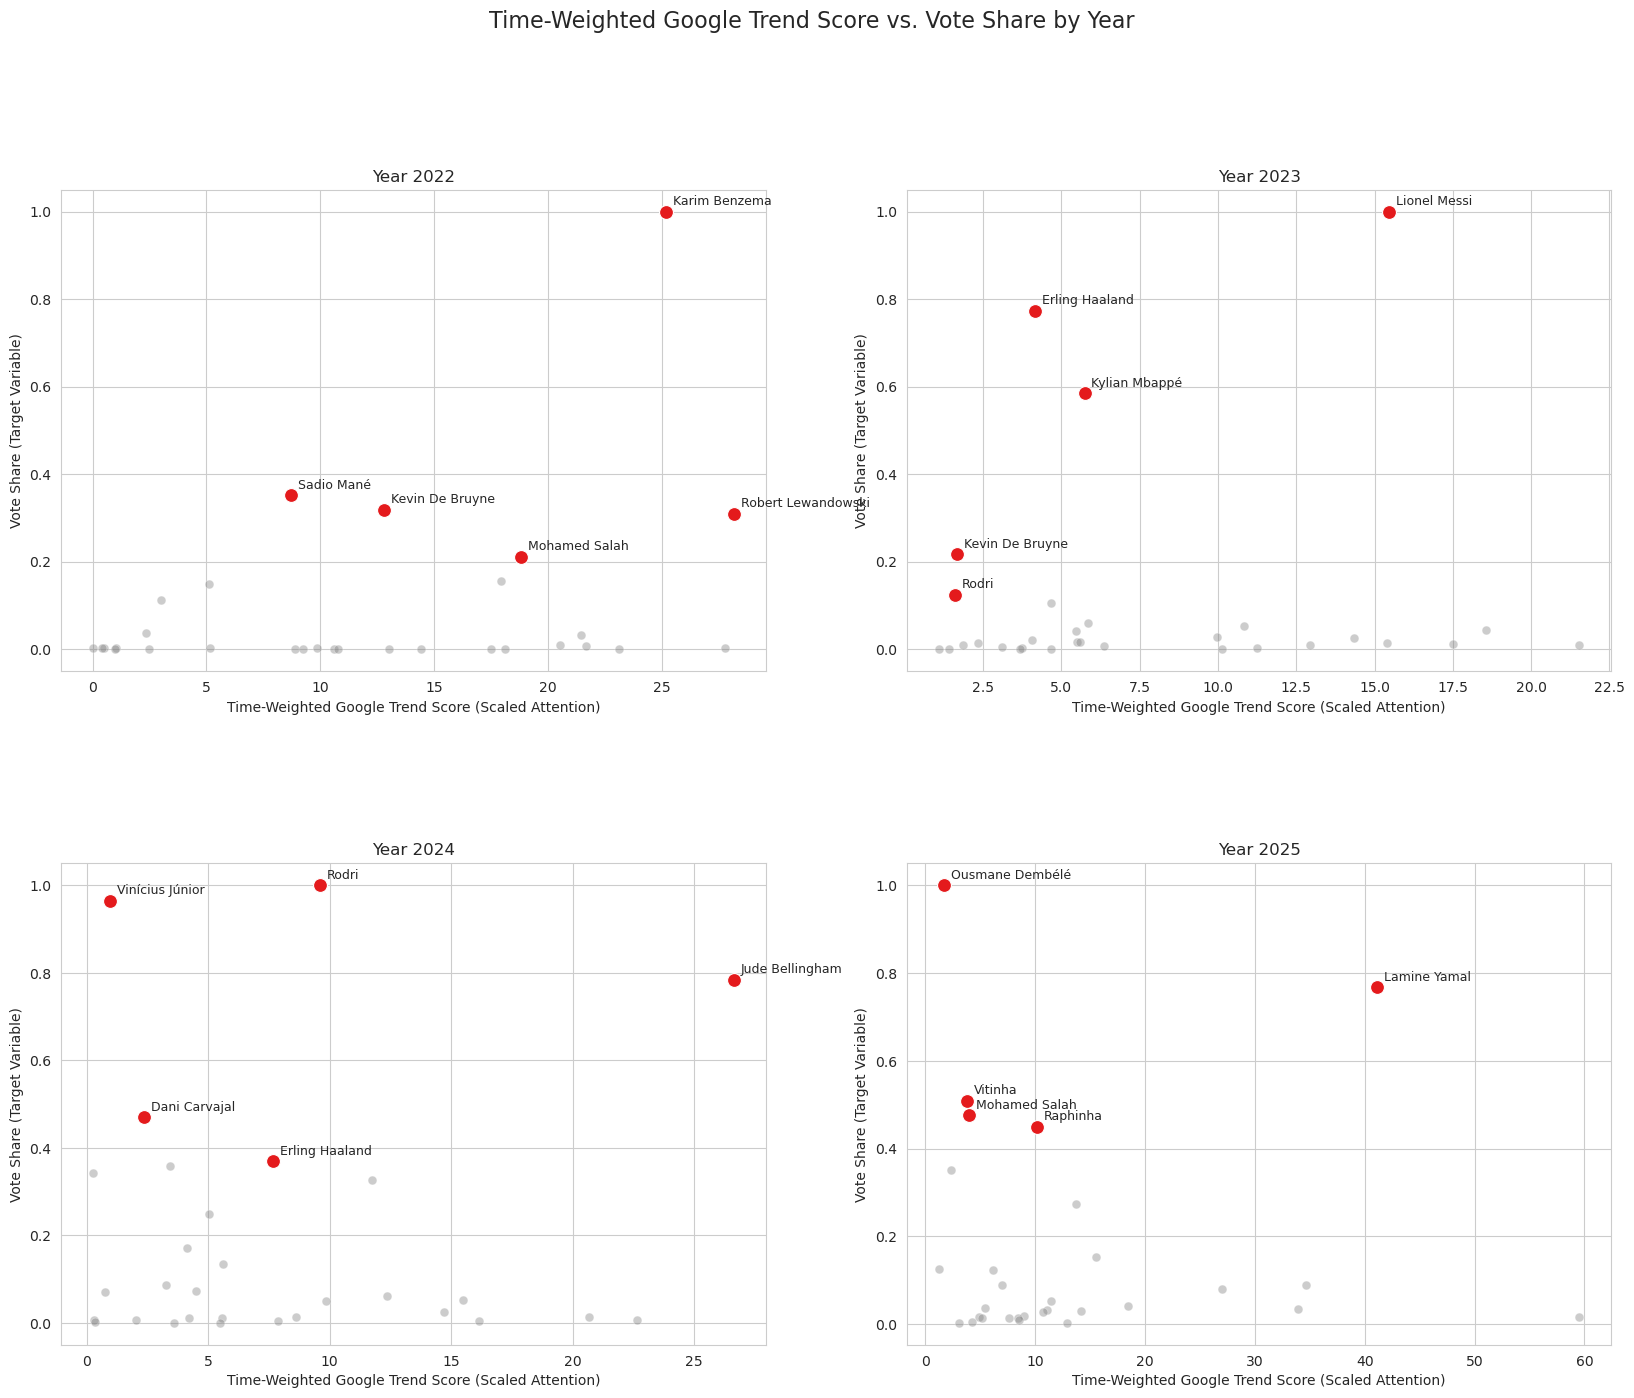

In [20]:
plt.figure(figsize=(20,15))
rows, cols = 2, 2
plt.suptitle('Time-Weighted Google Trend Score vs. Vote Share by Year', fontsize=16, y=1.0)
plt.subplots_adjust(hspace=0.4) # Add space between subplots

years = range(2022, 2026)

for i, year in enumerate(years):
    data_year = df[df['Year'] == year]
    
    # Sort and select top 5 players for high-visibility labeling
    top_players = data_year.nlargest(5, 'Vote Share') 

    plt.subplot(rows, cols, i+1)

    # 1. Plot all points (subdued color and smaller size)
    sns.scatterplot(
        x='Time-Weighted Google Trend Score', 
        y='Vote Share', 
        data=data_year, 
        alpha=0.4,
        color='gray',
        s=40 
    )
    
    # 2. Re-plot top players (highlighted color and larger size)
    sns.scatterplot(
        x='Time-Weighted Google Trend Score', 
        y='Vote Share', 
        data=top_players, 
        alpha=1.0,
        color=sns.color_palette("Set1")[0], # Highlight color (Red)
        s=100 
    )

    # 3. Add annotations for the top 5 players
    for index, row in top_players.iterrows():
        plt.annotate(
            row['Player'], 
            (row['Time-Weighted Google Trend Score'], row['Vote Share']),
            textcoords="offset points", 
            xytext=(5, 5), # Offset the label slightly from the point
            ha='left',
            fontsize=9
        )
    
    plt.title(f'Year {year}', fontsize=12)
    plt.xlabel('Time-Weighted Google Trend Score (Scaled Attention)')
    plt.ylabel('Vote Share (Target Variable)')

# Save the final figure once all subplots are complete
plt.savefig(REPORT_PATH + 'trend_vs_vote_share_labeled.png', bbox_inches='tight')

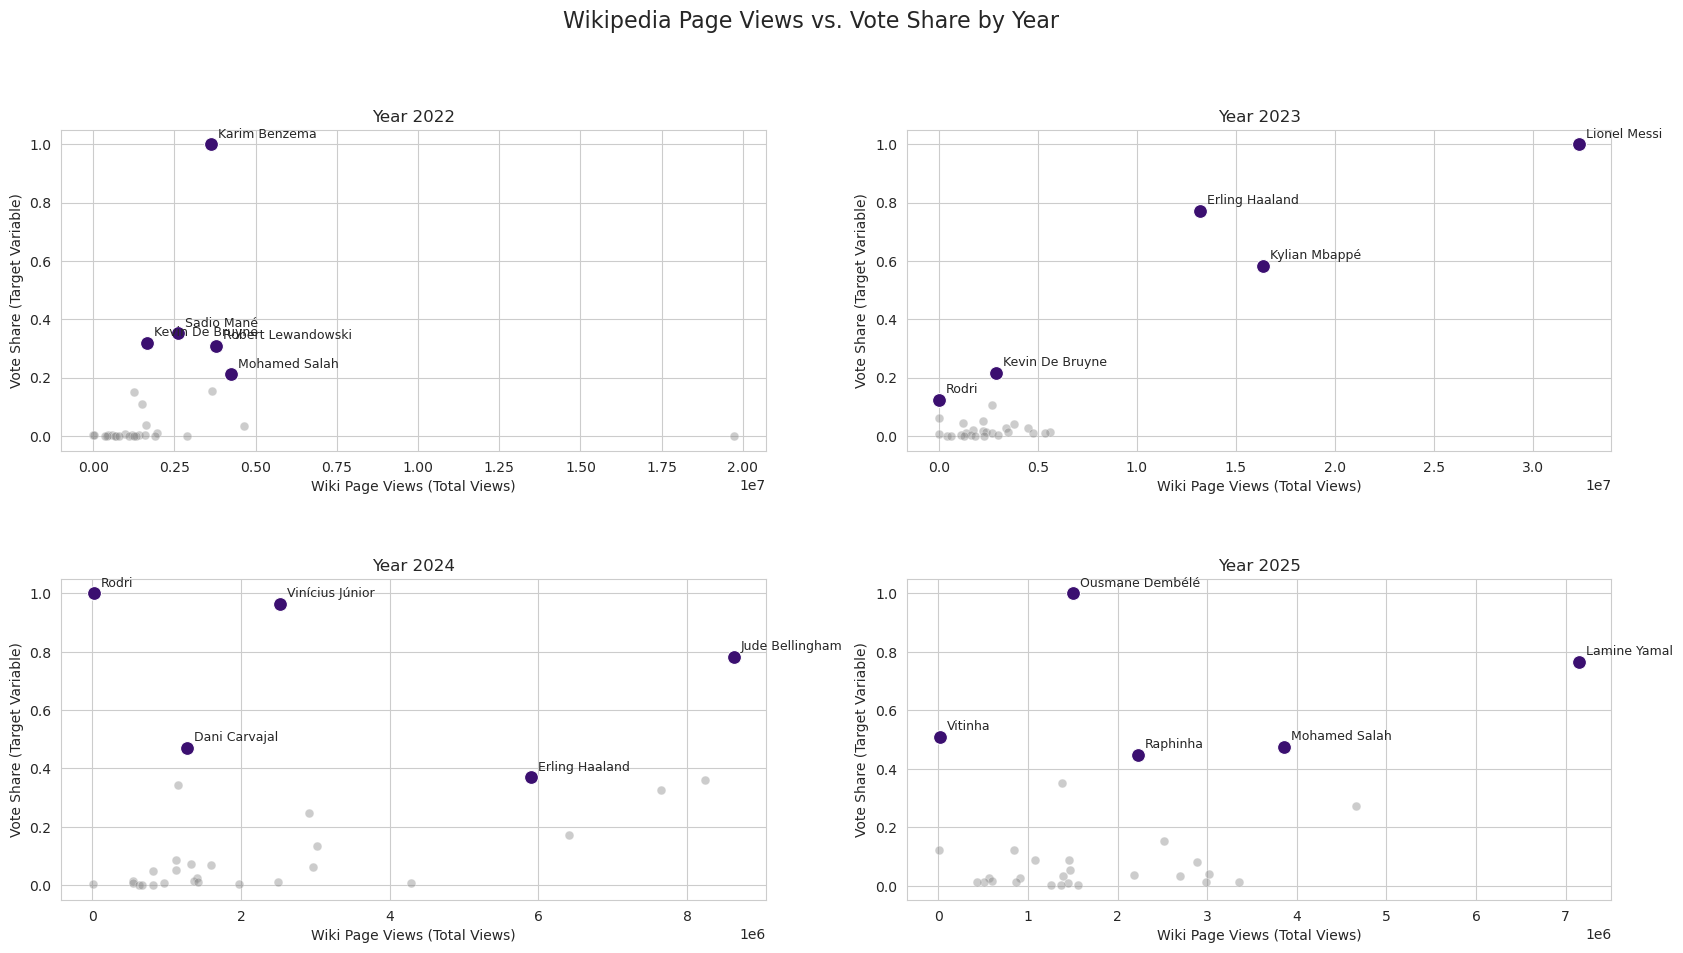

In [23]:
# Set up the 4x1 subplot grid
plt.figure(figsize=(20,10))
rows, cols = 2, 2
plt.suptitle('Wikipedia Page Views vs. Vote Share by Year', fontsize=16, y=1.0)
plt.subplots_adjust(hspace=0.4) 

years = range(2022, 2026)

for i, year in enumerate(years):
    data_year = df[df['Year'] == year]
    
    # Sort and select top 5 players for high-visibility labeling
    top_players = data_year.nlargest(5, 'Vote Share') 

    plt.subplot(rows,cols,i+1)
    # 1. Plot all points (subdued color and smaller size)
    sns.scatterplot(
        x='Wiki Page Views', 
        y='Vote Share', 
        data=data_year, 
        alpha=0.4,
        color='gray',
        s=40 
    )
    
    # 2. Re-plot top players (highlighted color and larger size)
    sns.scatterplot(
        x='Wiki Page Views', 
        y='Vote Share', 
        data=top_players, 
        alpha=1.0,
        color=sns.color_palette("magma", 4)[0], # Use a distinct color palette
        s=100 
    )

    # 3. Add annotations for the top 5 players
    for index, row in top_players.iterrows():
        plt.annotate(
            row['Player'], 
            (row['Wiki Page Views'], row['Vote Share']),
            textcoords="offset points", 
            xytext=(5, 5), # Offset the label slightly from the point
            ha='left',
            fontsize=9
        )
    
    plt.title(f'Year {year}', fontsize=12)
    plt.xlabel('Wiki Page Views (Total Views)') 
    plt.ylabel('Vote Share (Target Variable)')

# Save the final figure once all subplots are drawn
plt.savefig(REPORT_PATH + 'wiki_vs_vote_share_labeled.png', bbox_inches='tight')

### 2.4 Positional Analysis

Analyzing the relationship between player position and Vote Share to check for positional bias.

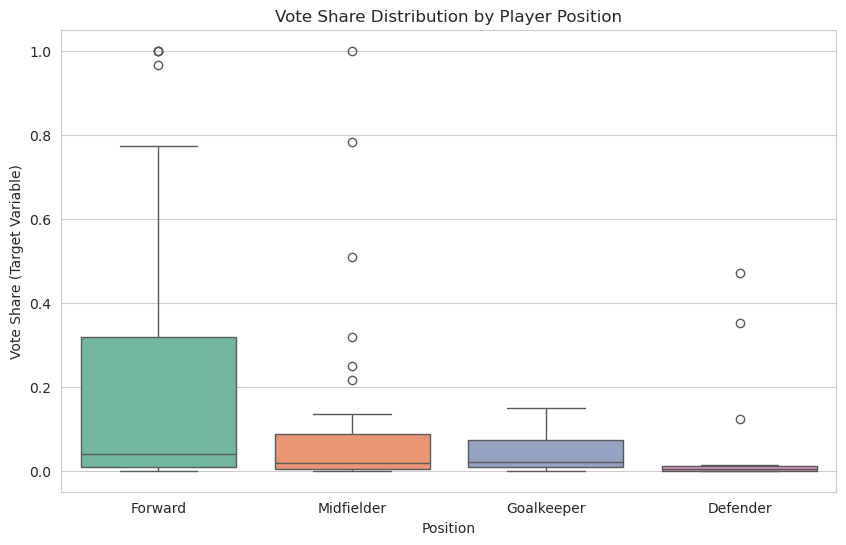

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Position', y='Vote Share', data=df, 
            hue='Position',
            palette='Set2')
plt.title('Vote Share Distribution by Player Position')
plt.xlabel('Position')
plt.ylabel('Vote Share (Target Variable)')
plt.savefig(REPORT_PATH + 'position_vs_vote_share_boxplot.png')
plt.show()

### 2.5 Achievement Rating Analysis: League and UCL Influence

To provide a baseline against the PR metrics, we must analyze the correlation between core on-field **achievement ratings** (League and UCL) and the final **Vote Share**. This helps quantify the predictive power of performance alone.

We use the same $4 \times 1$ stacked visualization for comparison across years.

Plot saved to ../reports/figures/league_rating_vs_vote_share_labeled.png


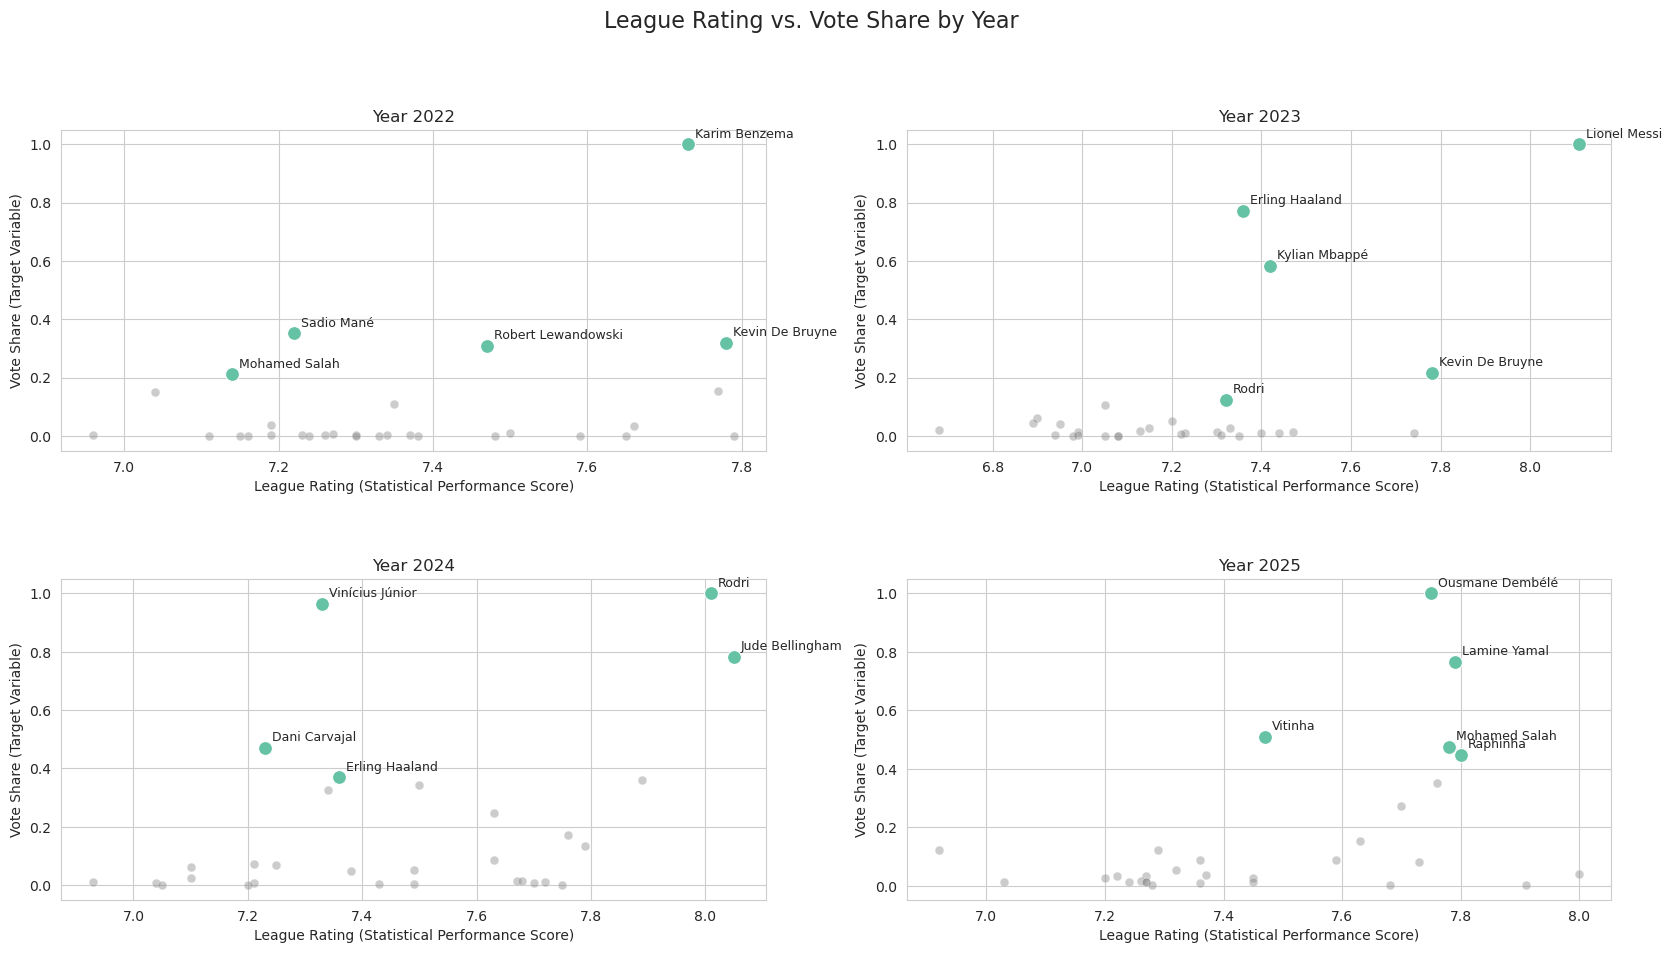

In [24]:
# Assuming df is the DataFrame with 'Vote Share' calculated and REPORT_PATH is defined.

plt.figure(figsize=(20,10))
rows, cols = 2, 2
plt.suptitle('League Rating vs. Vote Share by Year', fontsize=16, y=1.0)
plt.subplots_adjust(hspace=0.4) 

years = range(2022, 2026)

for i, year in enumerate(years):
    data_year = df[df['Year'] == year]
    
    # Sort and select top 5 players for high-visibility labeling
    top_players = data_year.nlargest(5, 'Vote Share') 

    plt.subplot(rows,cols,i+1)
    # 1. Plot all points (subdued color and smaller size)
    sns.scatterplot(
        x='League Rating', 
        y='Vote Share', 
        data=data_year, 
        alpha=0.4,
        color='gray',
        s=40 
    )
    
    # 2. Re-plot top players (highlighted color)
    sns.scatterplot(
        x='League Rating', 
        y='Vote Share', 
        data=top_players, 
        alpha=1.0,
        color=sns.color_palette("Set2", 4)[0], 
        s=100 
    )

    # 3. Add annotations for the top 5 players
    for index, row in top_players.iterrows():
        plt.annotate(
            row['Player'], 
            (row['League Rating'], row['Vote Share']),
            textcoords="offset points", 
            xytext=(5, 5), 
            ha='left',
            fontsize=9
        )
    
    plt.title(f'Year {year}', fontsize=12)
    plt.xlabel('League Rating (Statistical Performance Score)') 
    plt.ylabel('Vote Share (Target Variable)')

# Save the final figure
plt.savefig(REPORT_PATH + 'league_rating_vs_vote_share_labeled.png', bbox_inches='tight')
# plt.show()
print(f"Plot saved to {REPORT_PATH}league_rating_vs_vote_share_labeled.png")

Plot saved to ../reports/figures/ucl_rating_vs_vote_share_labeled.png


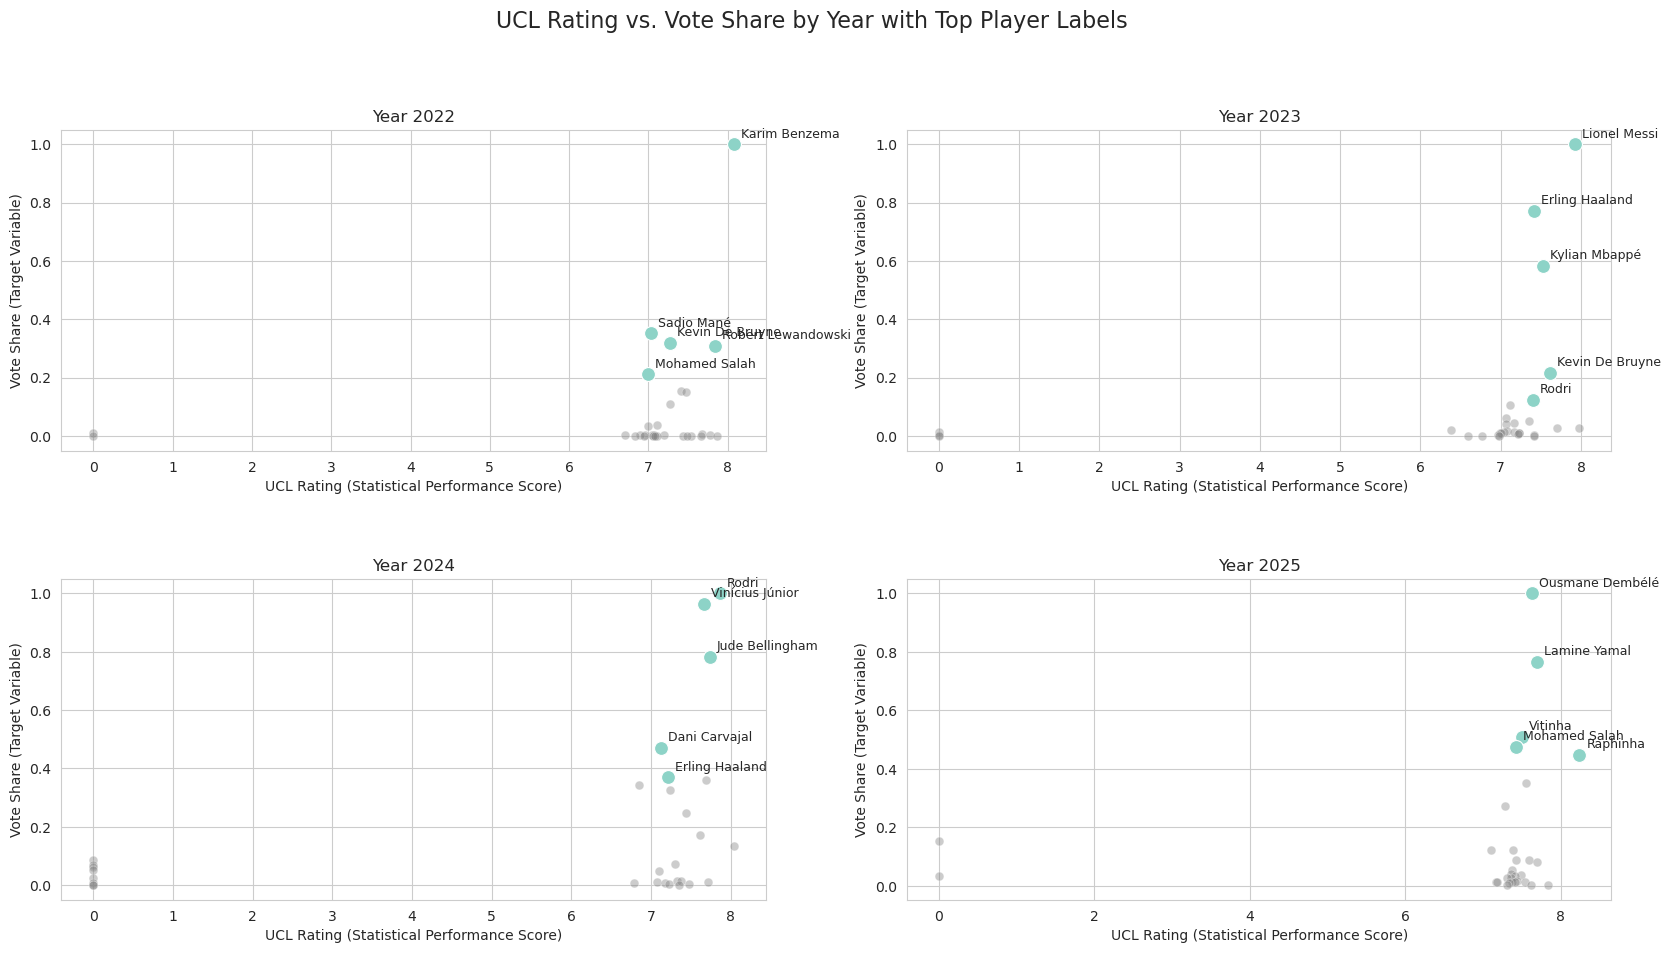

In [25]:
# Assuming df is the DataFrame with 'Vote Share' calculated and REPORT_PATH is defined.

rows, cols = 2, 2
plt.figure(figsize=(20,10))
rows, cols = 2, 2
plt.suptitle('UCL Rating vs. Vote Share by Year with Top Player Labels', fontsize=16, y=1.0)
plt.subplots_adjust(hspace=0.4) 

years = range(2022, 2026)

for i, year in enumerate(years):
    data_year = df[df['Year'] == year]
    
    # Sort and select top 5 players for high-visibility labeling
    top_players = data_year.nlargest(5, 'Vote Share') 

    plt.subplot(rows,cols,i+1)

    # 1. Plot all points (subdued color and smaller size)
    sns.scatterplot(
        x='UCL Rating', 
        y='Vote Share', 
        data=data_year, 
        alpha=0.4,
        color='gray',
        s=40 
    )
    
    # 2. Re-plot top players (highlighted color)
    sns.scatterplot(
        x='UCL Rating', 
        y='Vote Share', 
        data=top_players, 
        alpha=1.0,
        color=sns.color_palette("Set3", 4)[0], 
        s=100 
    )

    # 3. Add annotations for the top 5 players
    for index, row in top_players.iterrows():
        plt.annotate(
            row['Player'], 
            (row['UCL Rating'], row['Vote Share']),
            textcoords="offset points", 
            xytext=(5, 5), 
            ha='left',
            fontsize=9
        )
    
    plt.title(f'Year {year}', fontsize=12)
    plt.xlabel('UCL Rating (Statistical Performance Score)') 
    plt.ylabel('Vote Share (Target Variable)')

# Save the final figure
plt.savefig(REPORT_PATH + 'ucl_rating_vs_vote_share_labeled.png', bbox_inches='tight')
# plt.show()
print(f"Plot saved to {REPORT_PATH}ucl_rating_vs_vote_share_labeled.png")

In [26]:
# Drop temporary columns (Points, Max_Points) and save the intermediate file
df_eda = df.drop(columns=['Points', 'Max_Points'])

# Save the DataFrame with the new target variable for the Feature Engineering notebook
df_eda.to_csv('../data/02_eda_data.csv', index=False)

print("\nEDA completed. Data with 'Vote Share' saved to '../data/02_eda_data.csv'.")


EDA completed. Data with 'Vote Share' saved to '../data/02_eda_data.csv'.
